In [10]:
import sys
sys.path.append('/workspace/Documents')
# imports
import os, sys

# third party imports
import numpy as np 

import pandas as pd
import random
import nibabel as nb
import cv2
import ast
from scipy.ndimage import zoom
from skimage.measure import block_reduce

import Diffusion_motion_field.Build_lists.Build_list as Build_list
import Diffusion_motion_field.functions_collection as ff
import Diffusion_motion_field.Data_processing as Data_processing

main_path = '/mnt/camca_NAS/4DCT/models'

In [2]:
import numpy as np
from scipy.interpolate import interpn
from math import ceil

def extract_control_points_simple(dvf, spacing=(10,10,4), degree=3):
    """
    简单版本：从 dvf 中采样控制点（非拟合，只是 subsample + 线性插值）
    返回控制点值 + 控制点坐标
    """
    dvf = np.asarray(dvf)
    img_shape = dvf.shape
    spacing = np.array(spacing)

    ctrl_shape = [ceil(s / sp) + degree for s, sp in zip(img_shape, spacing)]
    ctrl_coords = [
        np.linspace(0, img_shape[d] - 1, ctrl_shape[d]) for d in range(3)
    ]
    mesh = np.meshgrid(*ctrl_coords, indexing='ij')  
    ctrl_grid_coords = np.stack(mesh, axis=-1)  
    flat_coords = ctrl_grid_coords.reshape(-1, 3)
    print(flat_coords.shape)

    # 采样控制点值（linear 插值）
    grid = [np.arange(s) for s in img_shape]  
    ctrl_vals = interpn(points=grid, values=dvf, xi=flat_coords, method='linear',bounds_error = False,fill_value =0)
    ctrl_vals = ctrl_vals.reshape(ctrl_grid_coords.shape[:-1]) 

    return ctrl_vals, ctrl_coords  

def interpolate_from_control_points(ctrl_vals, ctrl_coords, target_shape):
    """
    用控制点值和坐标，插值还原 full resolution DVF
    输出为 [X, Y, Z]
    """
    ctrl_coords_grid = np.meshgrid(*ctrl_coords, indexing='ij') 
    grid = [np.arange(s) for s in target_shape]  
    target_mesh = np.meshgrid(*grid, indexing='ij')  
    query_points = np.stack(target_mesh, axis=-1).reshape(-1, 3)

    dense_dvf = interpn(
        points=ctrl_coords,          
        values=ctrl_vals,            #
        xi=query_points,
        method='linear',
        bounds_error=False,
        fill_value=0
    ).reshape(*target_shape)


    return dense_dvf

In [18]:
patient_class = 'Normal'
patient_id = 'CVC2006041408'
mvf_file = os.path.join('/mnt/camca_NAS/4DCT/mvf_warp0_onecase/', patient_class, patient_id, 'voxel_final/5.nii.gz')
mvf = nb.load(mvf_file).get_fdata()
print(mvf.shape)
# pred_mvf = os.path.join('/mnt/camca_NAS/4DCT/models/MVF_EDM_latent_5tf_imgcon_EFcon_trial1/pred_mvf',patient_class, patient_id,'epoch5000_1/pred_decode_direct_tf5_x.nii.gz')
pred_mvf = os.path.join('/mnt/camca_NAS/4DCT/models/VAE_embed3/pred_mvf',patient_class, patient_id,'epoch54/pred_decode_direct_tf5_x.nii.gz')
# pred_mvf = os.path.join('/mnt/camca_NAS/4DCT/models/VAE_embed4_downsample8/pred_mvf',patient_class, patient_id,'epoch150/pred_decode_direct_tf5_x.nii.gz')
pred_mvf = nb.load(pred_mvf).get_fdata()


(160, 160, 96, 3)


In [19]:
# 假设输入为 [160,160,96]
import torch
dvf_x = mvf[:,:,:,0]
spacing = (4,4,4)

# simple
dvf_for_interp_simple = block_reduce(np.copy(dvf_x), (4,4,4), func=np.mean)
dense_dvf_final_simple = zoom(dvf_for_interp_simple, (4,4,4), order=1)

# B-spline
dvf_for_interp = np.copy(dvf_x)

# 控制点提取
ctrl_vals, ctrl_coords = extract_control_points_simple(dvf_for_interp, spacing=spacing, degree=3)
print('控制点：', ctrl_vals.shape)
print('控制点坐标：', ctrl_coords[0].shape, ctrl_coords[1].shape, ctrl_coords[2].shape)

# 插值回 dense DVF
dense_dvf_final = interpolate_from_control_points(ctrl_vals, ctrl_coords, target_shape=dvf_for_interp.shape)


print("插值结果 shape:", dense_dvf_final.shape)

(49923, 3)
控制点： (43, 43, 27)
控制点坐标： (43,) (43,) (27,)
插值结果 shape: (160, 160, 96)


mae between original and interpolated: 0.03059465557601933
mae between original and latent: 0.06747847541248934
mae between orignal and simple: 0.05208088646864138


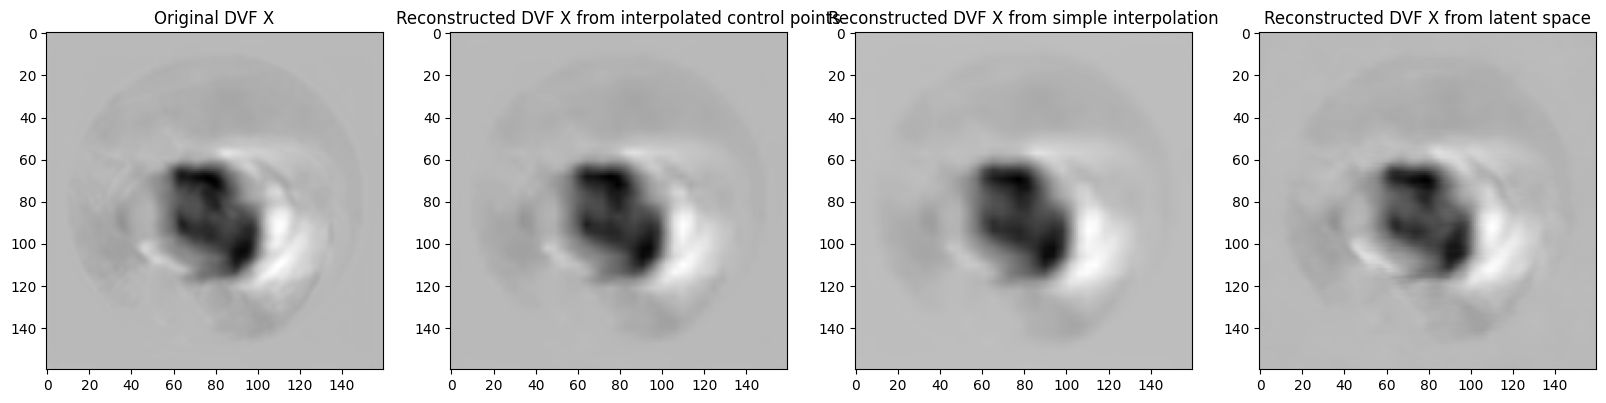

In [22]:
# visualize the results
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(20,5))
ax1 = figure.add_subplot(1, 4, 1)
ax1.imshow(np.flip(dvf_x[:, :, 51].T,0), cmap='gray')
ax1.set_title('Original DVF X')
ax2 = figure.add_subplot(1, 4, 2)
ax2.imshow(np.flip(dense_dvf_final[:, :, 51].T,0), cmap='gray')
ax2.set_title('Reconstructed DVF X from interpolated control points')
ax3 = figure.add_subplot(1, 4, 3)
ax3.imshow(np.flip(dense_dvf_final_simple[:, :, 51].T,0), cmap='gray')
ax3.set_title('Reconstructed DVF X from simple interpolation')
ax4 = figure.add_subplot(1, 4, 4)
ax4.imshow(np.flip(pred_mvf[:, :, 51].T,0), cmap='gray')
ax4.set_title('Reconstructed DVF X from latent space')
print('mae between original and interpolated:', np.mean(np.abs(dvf_x - dense_dvf_final)))
print('mae between original and latent:', np.mean(np.abs(dvf_x - pred_mvf)))
print('mae between orignal and simple:', np.mean(np.abs(dvf_x - dense_dvf_final_simple)))

